In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [6]:
print(tf.__version__)

2.8.0


In [7]:
BATCH_SIZE = 32
IMAGE_HEIGHT = 170
IMAGE_WIDTH=256
CHANNELS=3
EPOCHS=50

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "ADNI_DATASET",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    batch_size=BATCH_SIZE
)

Found 5358 files belonging to 4 classes.


In [9]:
class_names = dataset.class_names
class_names

['AD', 'CN', 'EMCI', 'MCI']

In [10]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 170, 256, 3)
[3 3 3 3 2 1 1 3 0 2 3 0 1 0 1 3 0 3 3 3 1 0 3 1 2 3 3 1 3 0 0 3]


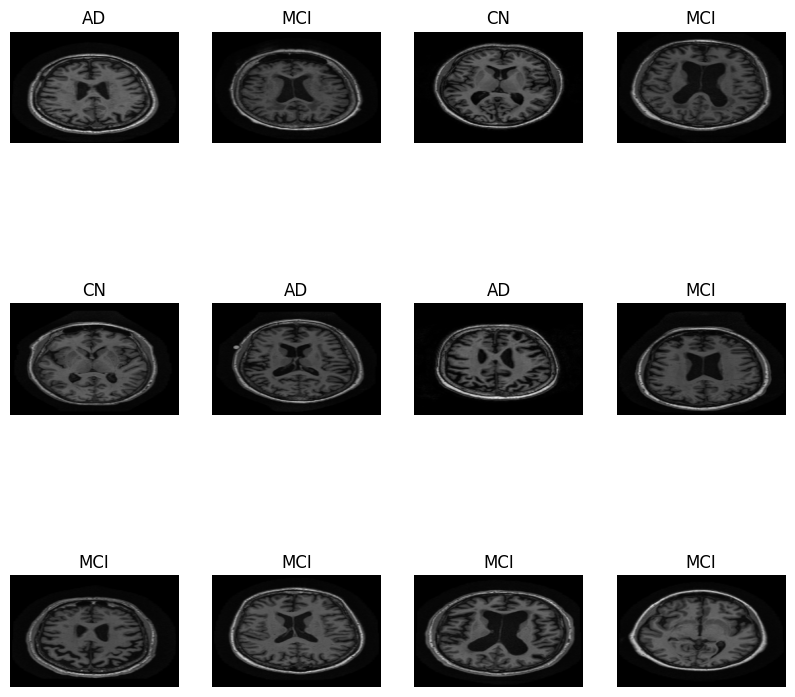

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [12]:
len(dataset)

168

In [13]:
train_size = 0.8
len(dataset)*train_size

134.4

In [14]:
train_ds = dataset.take(134)
len(train_ds)

134

In [15]:
test_ds = dataset.skip(134)
len(test_ds)

34

In [16]:
val_size=0.1
len(dataset)*val_size

16.8

In [17]:
val_ds = test_ds.take(16)
len(val_ds)

16

In [18]:
test_ds = test_ds.skip(16)
len(test_ds)

18

In [19]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [21]:
len(train_ds)

134

In [22]:
len(val_ds)

16

In [23]:
len(test_ds)

18

In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [26]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [27]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
input_shape = (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((1, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 170, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 168, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 84, 127, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 82, 125, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 41, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 39, 60, 64)         

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
134/134 [==============================] - 102s 756ms/step - loss: 1.0502 - accuracy: 0.5136 - val_loss: 0.9531 - val_accuracy: 0.5566
Epoch 2/50
134/134 [==============================] - 96s 716ms/step - loss: 0.9968 - accuracy: 0.5297 - val_loss: 0.9447 - val_accuracy: 0.5703
Epoch 3/50
134/134 [==============================] - 102s 763ms/step - loss: 0.9665 - accuracy: 0.5330 - val_loss: 0.9022 - val_accuracy: 0.5762
Epoch 4/50
134/134 [==============================] - 109s 811ms/step - loss: 0.9323 - accuracy: 0.5525 - val_loss: 0.8711 - val_accuracy: 0.5996
Epoch 5/50
134/134 [==============================] - 101s 750ms/step - loss: 0.9161 - accuracy: 0.5499 - val_loss: 0.8573 - val_accuracy: 0.6289
Epoch 6/50
134/134 [==============================] - 113s 846ms/step - loss: 0.8973 - accuracy: 0.5689 - val_loss: 0.8459 - val_accuracy: 0.6035
Epoch 7/50
134/134 [==============================] - 136s 1s/step - loss: 0.8687 - accuracy: 0.5852 - val_loss: 0.8070 - val

In [33]:
scores = model.evaluate(test_ds)

18/18 [==============================] - 5s 142ms/step - loss: 0.2536 - accuracy: 0.9115


In [34]:
scores

[0.25357046723365784, 0.9114583134651184]

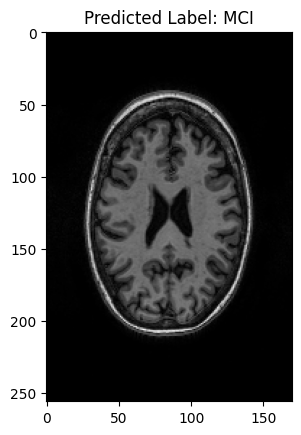

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match batch size
    return img_array

# Path to the image you want to predict
image_path = r"CI002_S_0729a093.png"

# Preprocess the image
image_data = preprocess_image(image_path)

# Predict using the model
predictions = model.predict(image_data)

# Get the predicted class index
predicted_class_index = np.argmax(predictions[0])

# Get the predicted class name
predicted_class_name = class_names[predicted_class_index]

# Display the image
plt.imshow(image.load_img(image_path))
plt.title("Predicted Label: " + predicted_class_name)
plt.show()


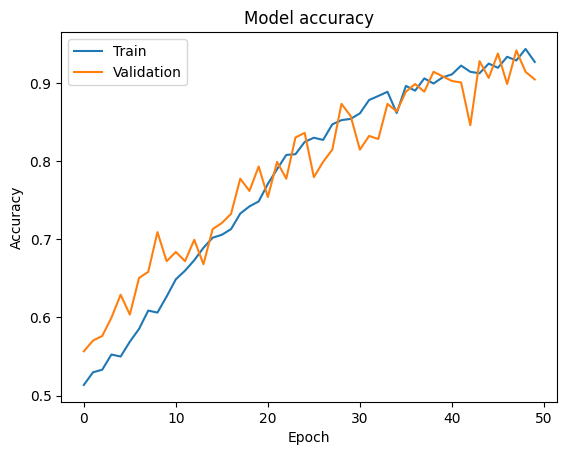

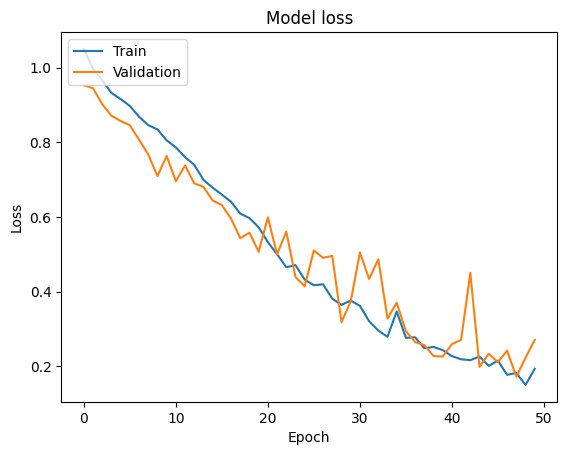

In [36]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy_plot.png')  # Save the accuracy plot as an image
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss_plot.png')  # Save the loss plot as an image
plt.show()


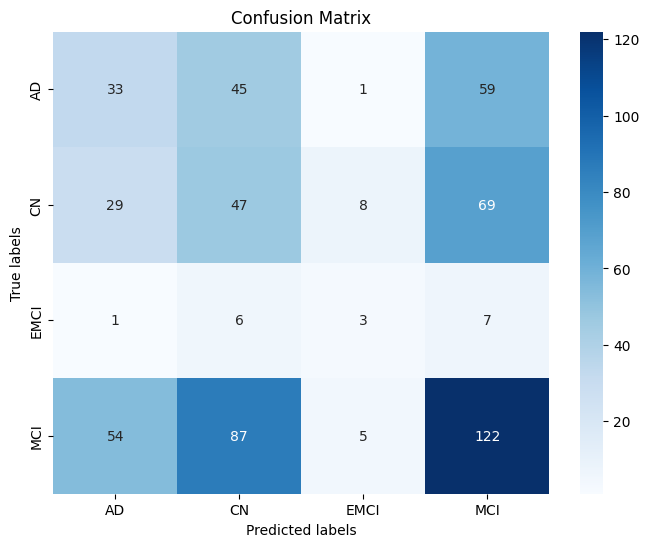

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict labels for the test set
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels for the test set
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix.png')  # Save the confusion matrix plot as an image
plt.show()


In [38]:
model_version=1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/1\assets
